In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader

In [ ]:

from google.colab import files


uploaded = files.upload()

Saving Val-1.csv to Val-1.csv


# Functions

In [ ]:
class MLFFNN(nn.Module):
    def __init__(self, input_size, num_hidden_layers, num_hidden_nodes, num_output_nodes):
        super(MLFFNN, self).__init__()

        self.num_classes = num_output_nodes

        self.layers = []

        self.layers += [nn.Linear(input_size, num_hidden_nodes[0]), nn.Sigmoid()]

        for i in range(num_hidden_layers - 1):
            self.layers += [nn.Linear(num_hidden_nodes[i], num_hidden_nodes[i+1]), nn.Sigmoid()]

        self.layers += [nn.Linear(num_hidden_nodes[-1], num_output_nodes)]

        self.fully_connected_layers = nn.Sequential(*self.layers)
        self.softmax = nn.Softmax()

    def forward(self, input):
        outputs = []
        for index, layer in enumerate(self.layers):
            input = layer(input)
            if index % 2==0 :
              outputs.append(input)

        out = self.softmax(input)
        predction = torch.argmax(out, 1)
        return input, predction, outputs

In [ ]:
class loader(Dataset):
    def __init__(self, X, y, model=None):
        self.X = X
        self.y = y
        self.num_classes = len(torch.unique(y))
        self.model = model

    def __len__(self):
        return self.X.shape[0]


def train(num_epochs, model_name, model, criterion, optimizer, train_loader, train_data, val_data, val_label, surface_plot_epochs=None):
    num_samples = len(train_loader)
    loss_dict = {"epoch" : [], "loss" : []}

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)

    for epoch in range(num_epochs):
        total_loss:float = 0.0
        correct = 0

        for (input, labels) in train_loader:
            model.train()

            input = input.to(device)
            labels = labels.to(device)

            output, pred, _ = model(input)

            correct += (pred == torch.argmax(labels, dim=1)).sum().item()

            labels = labels.to(torch.float32)
            loss = criterion(output, labels)

            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if(surface_plot_epochs is not None and (epoch + 1) in surface_plot_epochs):
            plot_node_surface(model, f"{model_name}, epoch={epoch+1}", train_data)

        if (epoch + 1) % 100 == 0:
            val_data = val_data.to(device)
            val_label = val_label.to(device)
            model.eval()
            with torch.no_grad():
                _, val_pred, _ = model(val_data)
                val_correct = (val_pred == val_label).sum().item()
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / num_samples}, Train Correct: {correct}, Val Correct: {val_correct}")
            loss_dict["epoch"].append(epoch + 1)
            loss_dict["loss"].append(total_loss / num_samples)

    if surface_plot_epochs is not None:
        plot_node_surface(model, f"{model_name}, epoch={num_epochs}", train_data)

    df = pd.DataFrame(loss_dict)
    print(df)
    #df.to_csv(f"{model_name}.csv", index=False)


def get_accuracy(model, X, y):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    X = X.to(device)
    y = y.to(device)

    _, pred, *args = model(X)
    correct = (pred == y).sum().item()
    return (correct / y.shape[0])

def confusion_matrix(model, X, y):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    X = X.to(device)

    _, pred,_ = model(X)
    pred = pred.cpu().numpy().flatten()
    label = y.numpy().flatten()
    print(confusion_matrix(label, pred))

In [ ]:
def plot_decision_boundary_mlffnn(model, model_name, train_data, train_label):
    X_train_numpy = train_data.numpy()
    y_train_numpy = train_label.numpy()
    classes = np.unique(y_train_numpy)

    x_min, x_max = X_train_numpy[:, 0].min() - 1, X_train_numpy[:, 0].max() + 1
    y_min, y_max = X_train_numpy[:, 1].min() - 1, X_train_numpy[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
    grid_input = np.c_[xx.ravel(), yy.ravel()]

    grid_input_tensor = torch.from_numpy(grid_input).float()

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    grid_input_tensor = grid_input_tensor.to(device)

    model.eval()
    with torch.no_grad():
        _, predictions, _ = model(grid_input_tensor)

    Z = predictions.cpu().numpy()
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z,cmap="magma",levels=50, alpha=0.95)

    for class_label in classes:
        indices = np.where(y_train_numpy == class_label)
        plt.scatter(X_train_numpy[indices, 0], X_train_numpy[indices, 1], s=20, edgecolor="black", label=f'Class {class_label}')

    print(model_name)
    plt.title('Decision Boundary of MLFFNN Classifier')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.show()
    #plt.savefig(model_name+".jpeg", dpi=300, format="jpeg")
    #plt.close()

def plot_node_surface(model, model_name, train_data):
    X_train_numpy = train_data.numpy()

    x_min, x_max = X_train_numpy[:, 0].min() - 1, X_train_numpy[:, 0].max() + 1
    y_min, y_max = X_train_numpy[:, 1].min() - 1, X_train_numpy[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    grid_input = np.c_[xx.ravel(), yy.ravel()]

    grid_input_tensor = torch.from_numpy(grid_input).float()

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    grid_input_tensor = grid_input_tensor.to(device)

    model.eval()
    with torch.no_grad():
        _, _, outputs = model(grid_input_tensor)

    num_hidden_layers = len(outputs)

    for hl in range(num_hidden_layers):
        z = torch.sigmoid(outputs[hl]).cpu().detach().numpy()
        num_nodes = z.shape[1]
        for nl in range(num_nodes):
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            z_ = z[:, nl]
            z_ = z_.reshape(xx.shape)

            ax.plot_surface(xx, yy, z_, cmap="turbo")
            if(hl != num_hidden_layers - 1):
                plt.title(f"Surface of node {nl+1} of hidden layer {hl+1}")
            else:
                plt.title(f"Surface of node {nl+1} of output layer")
            plt.xlabel("x1")
            plt.ylabel("x2")
            #plt.show()
            plt.savefig(f"{model_name}, node={nl}, hl={hl}.jpeg", dpi=300, format="jpeg")
            plt.close()

## 1-a

In [ ]:
train_df = pd.read_csv("Train-22.csv")
val_df = pd.read_csv("Val-22 (1).csv")
test_df = pd.read_csv("Test-22 (1).csv")

In [ ]:

train_data = torch.tensor(train_df[["input1", "input2"]].values, dtype=torch.float32)
train_label = torch.tensor(train_df["output"].values, dtype=torch.int64)

val_data = torch.tensor(val_df[["input1", "input2"]].values, dtype=torch.float32)
val_label = torch.tensor(val_df["output"].values, dtype=torch.int64)

test_data = torch.tensor(test_df[["input1", "input2"]].values, dtype=torch.float32)
test_label = torch.tensor(test_df["output"].values, dtype=torch.int64)

Epoch [100/1000], Loss: 0.009593687889355352, Train Correct: 359, Val Correct: 89
Epoch [200/1000], Loss: 0.01326457485120045, Train Correct: 358, Val Correct: 89
Epoch [300/1000], Loss: 0.010771182857570238, Train Correct: 358, Val Correct: 89
Epoch [400/1000], Loss: 0.011508709723011634, Train Correct: 359, Val Correct: 89
Epoch [500/1000], Loss: 0.00922143268326181, Train Correct: 359, Val Correct: 89
Epoch [600/1000], Loss: 0.01199314799109743, Train Correct: 359, Val Correct: 88
Epoch [700/1000], Loss: 0.010595710835877981, Train Correct: 358, Val Correct: 89
Epoch [800/1000], Loss: 0.012719435984035955, Train Correct: 358, Val Correct: 89
Epoch [900/1000], Loss: 0.008406936156643497, Train Correct: 359, Val Correct: 88
Epoch [1000/1000], Loss: 0.009686906368733617, Train Correct: 359, Val Correct: 89
   epoch      loss
0    100  0.009594
1    200  0.013265
2    300  0.010771
3    400  0.011509
4    500  0.009221
5    600  0.011993
6    700  0.010596
7    800  0.012719
8    900  0

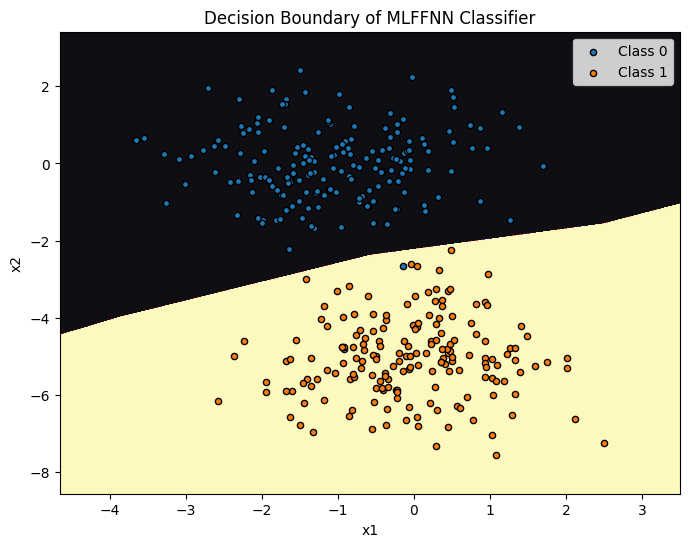

Train confusion matrix: 
[[181   1]
 [  0 178]]
Test confusion matrix: 
[[20  1]
 [ 0 29]]


In [ ]:
num_epochs = 1000
#num_hidden_nodes = [2,4,6,9]
#lr = [1,0.1,0.01,0.001,0.0001]
num_hidden_nodes = [6]
lr = [0.1]

train_loader = DataLoader(loader(train_data, train_label), batch_size = 36, shuffle=True)

input_size = train_data.shape[1]

accuracy = {"lr" : [], "num hidden nodes" : [], "Train Accuracy" : [], "Val Accuracy" : [], "Test Accuracy" : []}


for hn in num_hidden_nodes:
    for lr_ in lr:
        model = MLFFNN(input_size, 1, [hn,], 2)
        model_name = f"mlffnn classifier, hidden_nodes={hn}, lr={lr_}"

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr_)

        train(num_epochs, model_name, model, criterion, optimizer, train_loader, train_data, val_data, val_label)

        if lr_== 0.1 and hn==6 :
          plot_decision_boundary_mlffnn(model, model_name, train_data, train_label)
          print("Train confusion matrix: ")
          confusion_matrix(model, train_data, train_label)
          print("Test confusion matrix: ")
          confusion_matrix(model, test_data, test_label)

        accuracy["lr"].append(lr_)
        accuracy["num hidden nodes"].append(hn)
        accuracy["Train Accuracy"].append(get_accuracy(model, train_data, train_label))
        val_accuracy = get_accuracy(model, val_data, val_label)
        test_accuracy = get_accuracy(model, test_data, test_label)
        accuracy["Val Accuracy"].append(val_accuracy)
        accuracy["Test Accuracy"].append(test_accuracy)

#pd.DataFrame(accuracy).to_csv("mlffnn_accuracy.csv", index=False)

In [ ]:
input_size = val_data.shape[0]
input_size

90

## 1-b

In [ ]:
train_df = pd.read_csv("Train-1.csv")
val_df = pd.read_csv("Val-1.csv")
test_df = pd.read_csv("Test-1.csv")

In [ ]:
train_data = torch.tensor(train_df[["x1", "x2"]].values, dtype=torch.float32)
train_label = torch.tensor(train_df["label"].values, dtype=torch.int64)

val_data = torch.tensor(val_df[["x1", "x2"]].values, dtype=torch.float32)
val_label = torch.tensor(val_df["label"].values, dtype=torch.int64)

test_data = torch.tensor(test_df[["x1", "x2"]].values, dtype=torch.float32)
test_label = torch.tensor(test_df["label"].values, dtype=torch.int64)

In [ ]:
import random
torch.manual_seed(16)
np.random.seed(16)

In [ ]:
num_epochs = 1000
num_hidden_nodes1 = [3,6,9]
num_hidden_nodes2 = [3,6,9]
lr = [1]

train_loader = DataLoader(loader(train_data, train_label), batch_size = 80, shuffle=True)

input_size = train_data.shape[1]

accuracy = {"lr" : [], "number hidden nodes 1" : [], "number hidden nodes 2" : [], "Train Accuracy" : [], "Val Accuracy" : [], "Test Accuracy" : []}

for lr_ in lr:
    for hn1 in num_hidden_nodes1:
        for hn2 in num_hidden_nodes2:
            print(f"Training:{lr_}, {hn1}, {hn2}")
            torch.manual_seed(16)
            np.random.seed(16)
            model = MLFFNN(input_size, 2, [hn1, hn2], 2)
            model_name = f"mlffnn, lr={lr_}, hidden_nodes1={hn1}, hidden_nodes2={hn2}"

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr_)

            train(num_epochs, model_name, model, criterion, optimizer, train_loader, train_data, val_data, val_label)

            #plot_decision_boundary_mlffnn(model, model_name, train_data, train_label)

            accuracy["lr"].append(lr_)
            accuracy["num hidden nodes 1"].append(hn1)
            accuracy["num hidden nodes 2"].append(hn2)
            accuracy["Train Accuracy"].append(get_accuracy(model, train_data, train_label))
            val_accuracy = get_accuracy(model, val_data, val_label)
            accuracy["Val Accuracy"].append(val_accuracy)
            accuracy["Test Accuracy"].append(get_accuracy(model, test_data, test_label))

pd.DataFrame(accuracy).to_csv("mlffnn_a.csv", index=False)

Training:1, 3, 3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


   epoch      loss
0    100  0.691341
1    200  0.738248
2    300  0.863303
3    400  0.688381
4    500  0.685393
5    600  0.796955
6    700  0.735645
7    800  0.745448
8    900  0.846971
9   1000  0.873590
Training:1, 3, 6


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


   epoch          loss
0    100  7.979927e-05
1    200  2.775179e-05
2    300  1.285303e-05
3    400  7.785621e-06
4    500  3.693053e-06
5    600  2.631353e-06
6    700  1.814773e-06
7    800  1.168436e-06
8    900  7.022168e-07
9   1000  4.118307e-07
Training:1, 3, 9


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


   epoch      loss
0    100  0.835894
1    200  0.882390
2    300  0.715676
3    400  0.801396
4    500  0.729180
5    600  0.711438
6    700  0.734082
7    800  0.734304
8    900  0.733521
9   1000  0.699564
Training:1, 6, 3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


   epoch          loss
0    100  2.577725e-05
1    200  1.612659e-05
2    300  9.656071e-06
3    400  6.479927e-06
4    500  3.505861e-06
5    600  2.470608e-06
6    700  1.776589e-06
7    800  1.145153e-06
8    900  7.048246e-07
9   1000  4.386528e-07
Training:1, 6, 6


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


   epoch      loss
0    100  0.704974
1    200  0.711768
2    300  0.738215
3    400  0.692242
4    500  0.792366
5    600  0.710147
6    700  0.717113
7    800  0.737956
8    900  0.742761
9   1000  0.678574
Training:1, 6, 9


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


   epoch      loss
0    100  0.883700
1    200  0.000572
2    300  0.000114
3    400  0.000047
4    500  0.000026
5    600  0.000014
6    700  0.000010
7    800  0.000006
8    900  0.000004
9   1000  0.000002
Training:1, 9, 3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


   epoch      loss
0    100  0.836443
1    200  0.883632
2    300  0.715700
3    400  0.801346
4    500  0.729190
5    600  0.711430
6    700  0.734078
7    800  0.734304
8    900  0.733521
9   1000  0.699564
Training:1, 9, 6


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


   epoch      loss
0    100  0.786010
1    200  0.904672
2    300  0.727709
3    400  0.742831
4    500  0.720320
5    600  0.763745
6    700  0.727416
7    800  0.856074
8    900  0.992369
9   1000  0.748739
Training:1, 9, 9


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


   epoch      loss
0    100  0.894125
1    200  0.784786
2    300  0.712921
3    400  0.764018
4    500  1.055097
5    600  0.677901
6    700  0.831184
7    800  0.861033
8    900  0.761477
9   1000  0.858471


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
print(accuracy)

{'lr': [0.1], 'num hidden nodes 1': [6], 'num hidden nodes 2': [2], 'Train Accuracy': [1.0], 'Val Accuracy': [1.0], 'Test Accuracy': [1.0]}


In [ ]:
input_size= train_data.shape[1]

In [ ]:
model = MLFFNN(input_size, 2, [6, 3], 2)
model_name = "mlffnn, hidden_nodes1=6, hidden_nodes2=6,"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

train_loader = DataLoader(loader(train_data, train_label), batch_size = 80, shuffle=True)



In [ ]:
surface_plot_epochs = [20,100]
num_epochs = 100

In [ ]:
train(num_epochs, model_name, model, criterion, optimizer, train_loader, train_data, val_data, val_label, surface_plot_epochs)

Epoch [100/100], Loss: 0.00011297983473923523, Train Correct: 562, Val Correct: 159
   epoch      loss
0    100  0.000113
